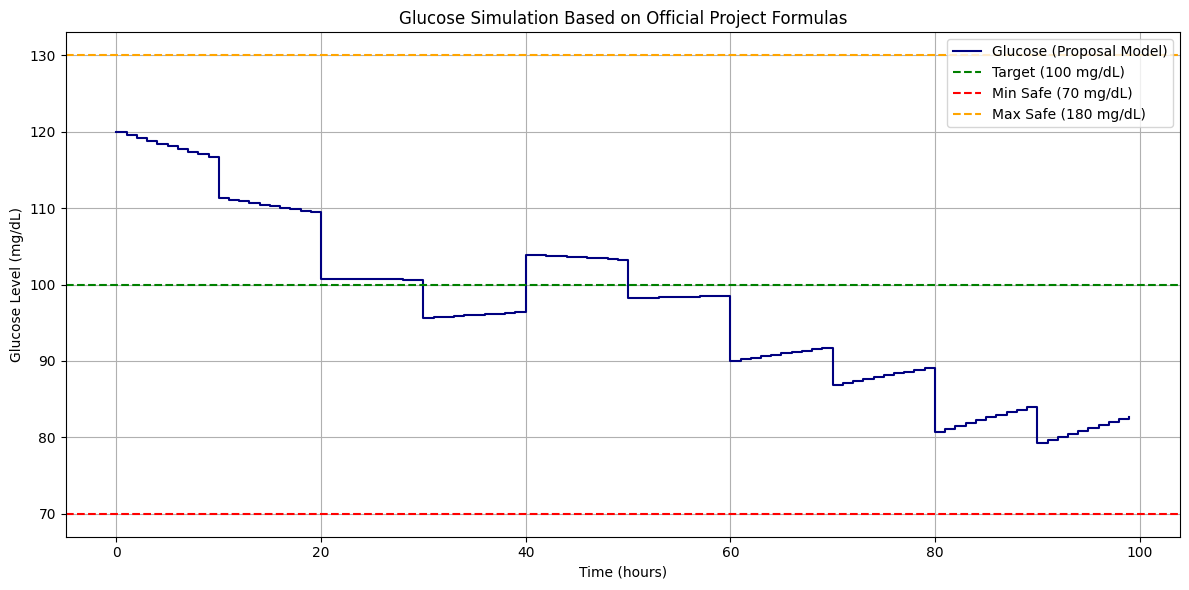

In [ ]:
# Implementing the official simulation using the EXACT formulas from the proposal
# TO DO: Simulation Loop - 6hours Interval

import numpy as np
import matplotlib.pyplot as plt

# Parameters from Proposal
BW = 80                 # Body weight (kg)
Vd = 0.2                # Glucose distribution volume (L/kg)
k = 1.0                 # Carb-to-glucose conversion factor (mg/dL per gram)
S = 10                  # Insulin sensitivity (mg/dL per unit)
p1 = 0.02               # Natural clearance rate
R = 0.1                 # Glucose drop per kcal burned
G_target = 100          # Target glucose (mg/dL)
G_min = 70              # Safety minimum
G_max = 130             # Safety maximum

# Simulation settings
hours = 100
time_step = 1           # 1 hour
G = np.zeros(hours)
G[0] = 120        # Start at target level

# Event schedules
meal_schedule = [20, 40, 60, 80, 100]
insulin_schedule = [10, 30, 50, 70, 90]
exercise_schedule = [20, 60, 80]

# Event values
C = 120  # grams of carbs
D = 0.5   # units of insulin
calories_burned = BW * 4 * 30 / 60  # MET=4, 30min

# Simulation loop
for t in range(1, hours):
    G_prev = G[t - 1]

    # Apply proposal formulas
    G_rise = (k * C) / (BW * Vd) if t in meal_schedule else 0
    G_red = S * D if t in insulin_schedule else 0
    G_clear = p1 * (G_prev - G_target)
    G_burn = R * calories_burned if t in exercise_schedule else 0

    # Glucose update from official formula
    G_new = G_prev + G_rise - G_red - G_clear - G_burn
    G[t] = min(max(G_new, G_min), G_max)

# Plotting
plt.figure(figsize=(12, 6))
plt.step(range(hours), G, where='post', label="Glucose (Proposal Model)", color='navy')
plt.axhline(y=G_target, linestyle='--', color='green', label='Target (100 mg/dL)')
plt.axhline(y=G_min, linestyle='--', color='red', label='Min Safe (70 mg/dL)')
plt.axhline(y=G_max, linestyle='--', color='orange', label='Max Safe (180 mg/dL)')
plt.xlabel("Time (hours)")
plt.ylabel("Glucose Level (mg/dL)")
plt.title("Glucose Simulation Based on Official Project Formulas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


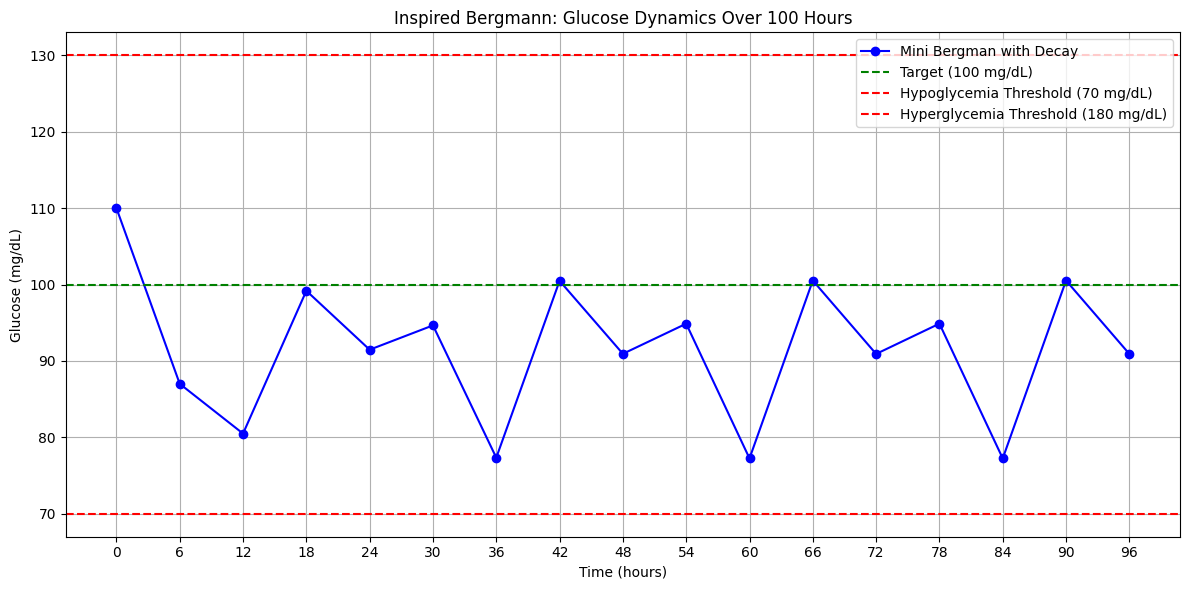

Total glucose deviation (objective value): 154.36


In [ ]:
# ------------------------------------------------------------
# MODEL 2: INSPIRED MINI BERGMAN - factor is choosen
# ------------------------------------------------------------

# TO Do: Align Simulation Loop?


# --- Shared Input Parameters ---
body_weight = 80              # kg
initial_glucose = 110         # mg/dL
volume_density = 200          # mL/kg
clearance_time_const = 240    # min
insulin_sensitivity = 10      # mg/dL per unit insulin
carbs_per_meal = 50           # grams
k = 8                         # mg/dL per gram carb
glucose_target = 100          # mg/dL
interval = 360                # 6 hours = 360 minutes
met = 4                       # exercise intensity
exercise_duration = 20        # minutes
r = 0.15                      # glucose drop per kcal
p2 = 0.02                     # insulin decay rate (1/h)
ka = 0.3                      # glucose absorption decay (1/h)
clearance_decay = 0.01        # clearance decay (1/h)
insulin_dose = 1              # fixed for each step
hours = 100                   # total simulation time

# --- Functions ---
def glucose_rise(carbs, k, bw, vd, ka, t):
    dose = (carbs * k) / (bw * vd)
    return dose * ka * np.exp(-ka * t)

def effective_glucose_drop(insulin_dose, sensitivity, p2, interval):
    return insulin_dose * sensitivity * np.exp(-p2 * (interval / 60))

def calories_burned(bw, met, exercise_time):
    return (bw * met * exercise_time) / 60

def glucose_clearance(glucose_level, target, clearance_const, interval, decay_rate):
    base = ((glucose_level - target) / clearance_const) * interval
    return base * np.exp(-decay_rate * (interval / 60))

def energy_expenditure(calories, r):
    return calories * r

def objective_interval(glucose_level, next_glucose, target):
    return abs(next_glucose - target)

def simulate_interval(glucose_level, meal_carbs, insulin_dose, p2, interval, ka, clearance_decay, exercise=False):
    t_avg = interval / 120  # midpoint in hours
    G_rise = glucose_rise(meal_carbs, k, body_weight, volume_density, ka, t_avg)
    G_drop = effective_glucose_drop(insulin_dose, insulin_sensitivity, p2, interval)
    G_clear = glucose_clearance(glucose_level, glucose_target, clearance_time_const, interval, clearance_decay)
    G_burn = energy_expenditure(calories_burned(body_weight, met, exercise_duration), r) if exercise else 0
    G_next = glucose_level + G_rise - G_drop - G_clear - G_burn
    return max(G_next, 40)

def simulate_long_period(hours, insulin_dose, p2, ka, clearance_decay, exercise_pattern):
    num_intervals = hours // 6
    glucose_profile = [initial_glucose]
    current_glucose = initial_glucose
    objectives = []

    for i in range(num_intervals):
        exercise = exercise_pattern[i % len(exercise_pattern)]
        next_glucose = simulate_interval(current_glucose, carbs_per_meal, insulin_dose, p2, interval, ka, clearance_decay, exercise)
        objectives.append(objective_interval(current_glucose, next_glucose, glucose_target))
        glucose_profile.append(next_glucose)
        current_glucose = next_glucose

    return glucose_profile, sum(objectives)

# --- Run Simulation ---
exercise_pattern = [False, True, False, False] * (hours // 24 + 1)
glucose_profile1, total_obj1 = simulate_long_period(
    hours, insulin_dose, p2, ka, clearance_decay, exercise_pattern
)

# --- Plot ---
time_steps = np.arange(0, len(glucose_profile1) * 6, 6)
plt.figure(figsize=(12, 6))
plt.plot(time_steps, glucose_profile1, marker='o', color='blue', label='Mini Bergman with Decay')
plt.axhline(y=glucose_target, color='green', linestyle='--', label='Target (100 mg/dL)')
plt.axhline(y=70, color='red', linestyle='--', label='Hypoglycemia Threshold (70 mg/dL)')
plt.axhline(y=130, color='red', linestyle='--', label='Hyperglycemia Threshold (180 mg/dL)')
plt.title("Inspired Bergmann: Glucose Dynamics Over 100 Hours")
plt.xlabel("Time (hours)")
plt.ylabel("Glucose (mg/dL)")
plt.xticks(np.arange(0, 101, 6))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total glucose deviation (objective value): {total_obj1:.2f}")

Simulation completed over 100.0 hours with 6001 time steps


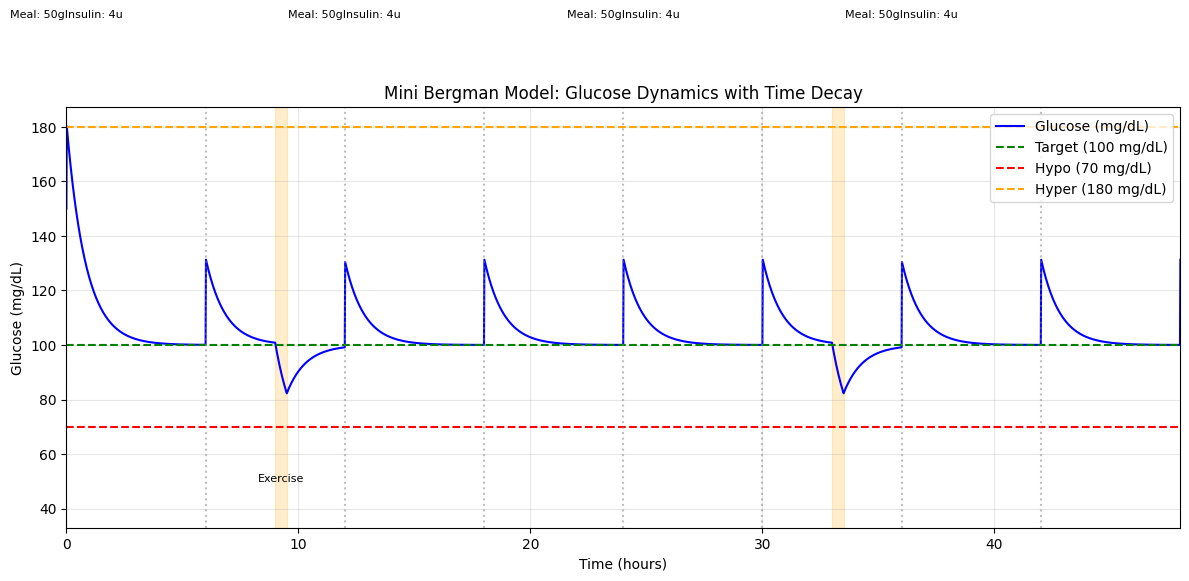

In [ ]:
# Improved Mini Bergman Model Simulation
# Focus on correct dynamics with proper time decay

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# -------------------- Model Constants --------------------
body_weight = 80          # kg
volume_density = 0.2      # L/kg (distribution volume)
k = 0.01                  # glucose rise per gram carb (mg/dL per g)
p1 = 0.02                 # glucose effectiveness at zero insulin (per min)
p2 = 0.025/60             # insulin action decay rate (per min)
p3 = 0.000013             # insulin sensitivity (per min per μU/mL)
SI = 20                   # insulin sensitivity factor (mg/dL per unit)
glucose_target = 100      # mg/dL
min_glucose = 70          # mg/dL
max_glucose = 180         # mg/dL
exercise_effect = 0.15    # mg/dL drop per kcal

# -------------------- Simulation Setup --------------------
# 100-hour simulation with 1-minute time steps
simulation_time = 100 * 60  # minutes (100 hours)
time_step = 1               # 1-minute time step
num_steps = simulation_time // time_step + 1
time_vec = np.linspace(0, simulation_time, num_steps)

# Define meal schedule: meals every 6 hours
meal_interval = 6 * 60  # 6 hours in minutes
num_meals = simulation_time // meal_interval + 1
meal_times = [i * meal_interval for i in range(int(num_meals))]
meal_carbs = [50] * int(num_meals)  # 50g carbs per meal

# Define insulin doses (administered with meals)
insulin_doses = [4] * int(num_meals)  # 4 units per meal

# Define exercise periods (once per day)
exercise_interval = 24 * 60  # 24 hours in minutes
num_exercises = simulation_time // exercise_interval
exercise_times = [9 * 60 + i * exercise_interval for i in range(int(num_exercises))]  # 9 AM each day
exercise_durations = [30] * int(num_exercises)  # 30 minutes each

# -------------------- Simulation Function --------------------
def simulate_glucose_dynamics(initial_glucose, p2, insulin_doses, meal_times, meal_carbs,
                             exercise_times, exercise_durations):
    """
    Simulate glucose dynamics using the mini Bergman model with proper time decay

    Parameters:
    - initial_glucose: Starting glucose level (mg/dL)
    - p2: Insulin action decay rate (per min)
    - insulin_doses: List of insulin doses (units)
    - meal_times: List of meal times (minutes from start)
    - meal_carbs: List of carbohydrate amounts per meal (g)
    - exercise_times: List of exercise start times (minutes from start)
    - exercise_durations: List of exercise durations (minutes)

    Returns:
    - time_vec: Time vector (minutes)
    - G: Glucose levels over time (mg/dL)
    - X: Insulin action state over time
    - I: Plasma insulin concentration over time
    """
    # Initialize arrays
    G = np.zeros(num_steps)  # Glucose concentration (mg/dL)
    X = np.zeros(num_steps)  # Insulin action (remote insulin)
    I = np.zeros(num_steps)  # Plasma insulin concentration

    # Set initial conditions
    G[0] = initial_glucose
    X[0] = 0  # Initial insulin action
    I[0] = 0  # Initial plasma insulin

    # Track components for analysis
    meal_effect = np.zeros(num_steps)
    insulin_effect = np.zeros(num_steps)
    clearance_effect = np.zeros(num_steps)
    exercise_effect_trace = np.zeros(num_steps)

    # Simulation loop using Euler method with small time step
    for t in range(1, num_steps):
        current_time = (t-1) * time_step

        # 1. Check for meals (glucose rise)
        meal_glucose_rise = 0
        for m_time, carbs in zip(meal_times, meal_carbs):
            if m_time <= current_time < m_time + time_step:
                # Convert carbs to glucose rise (mg/dL)
                meal_glucose_rise = carbs * k * 1000 / (body_weight * volume_density)

        # 2. Check for insulin doses (plasma insulin rise)
        insulin_dose = 0
        for i_time, dose in zip(meal_times, insulin_doses):  # Insulin given with meals
            if i_time <= current_time < i_time + time_step:
                insulin_dose = dose
                # Convert units to plasma concentration (μU/mL)
                I[t] = I[t-1] + insulin_dose * 1000 / (body_weight * volume_density)
            else:
                # Insulin clearance from plasma (simplified)
                I[t] = I[t-1] * 0.95  # Assume 5% clearance per minute

        # 3. Update insulin action state X (remote insulin compartment)
        # dX/dt = -p2 * X + p3 * (I - Ib)
        # Here we simplify by assuming Ib (basal insulin) is 0
        X[t] = X[t-1] + time_step * (-p2 * X[t-1] + p3 * I[t-1])

        # 4. Check for exercise effect
        exercise_glucose_drop = 0
        for ex_time, ex_dur in zip(exercise_times, exercise_durations):
            if ex_time <= current_time < ex_time + ex_dur:
                # Calculate calories burned during this minute
                cal_per_min = body_weight * 4 / 60  # MET of 4, per minute
                exercise_glucose_drop = cal_per_min * exercise_effect

        # 5. Calculate glucose dynamics
        # dG/dt = -p1 * (G - Gb) - X * G + meal_rise - exercise_effect
        # Here Gb is the target glucose level

        # Natural glucose clearance (effectiveness at zero insulin)
        clearance = p1 * (G[t-1] - glucose_target)

        # Insulin-dependent glucose utilization
        insulin_dependent_utilization = X[t] * G[t-1]

        # Update glucose level
        G[t] = G[t-1] + time_step * (
            -clearance                    # Natural clearance
            - insulin_dependent_utilization  # Insulin effect
            + meal_glucose_rise           # Meal effect
            - exercise_glucose_drop       # Exercise effect
        )

        # Ensure glucose doesn't go below 40 mg/dL (physiological constraint)
        G[t] = max(G[t], 40)

        # Store component effects for analysis
        meal_effect[t] = meal_glucose_rise
        insulin_effect[t] = insulin_dependent_utilization
        clearance_effect[t] = clearance
        exercise_effect_trace[t] = exercise_glucose_drop

    return time_vec, G, X, I, meal_effect, insulin_effect, clearance_effect, exercise_effect_trace

# -------------------- Objective Function --------------------
def objective_function(G, target):
    """Calculate objective function to minimize (lower is better)"""
    # Mean error from target
    mse = np.mean((G - target))

    # Penalty for hypoglycemia (glucose < 70)
    hypo_penalty = np.sum((G < min_glucose) * (min_glucose - G) ** 2)

    # Penalty for hyperglycemia (glucose > 180)
    hyper_penalty = np.sum((G > max_glucose) * (G - max_glucose) ** 2)

    # Combined objective
    return mse + 5 * hypo_penalty + 2 * hyper_penalty

# -------------------- Run Simulation --------------------
initial_glucose = 150  # starting glucose level

# Run simulation
time_vec, G, X, I, meal_effect, insulin_effect, clearance_effect, exercise_effect_trace = simulate_glucose_dynamics(
    initial_glucose, p2, insulin_doses, meal_times, meal_carbs, exercise_times, exercise_durations
)

# Calculate objective function value
obj_val = objective_function(G, glucose_target)
print(f'Simulation completed over {simulation_time/60:.1f} hours with {num_steps} time steps')

# -------------------- Plotting --------------------
# Convert time to hours for plotting
time_hours = time_vec / 60

# Plot glucose dynamics with key events
plt.figure(figsize=(12, 6))
plt.plot(time_hours, G, 'b-', linewidth=1.5, label='Glucose (mg/dL)')
plt.axhline(y=glucose_target, color='green', linestyle='--', label='Target (100 mg/dL)')
plt.axhline(y=min_glucose, color='red', linestyle='--', label='Hypo (70 mg/dL)')
plt.axhline(y=max_glucose, color='orange', linestyle='--', label='Hyper (180 mg/dL)')

# Mark first few meals and insulin doses (to avoid cluttering)
for i, (m_time, carbs, dose) in enumerate(zip(meal_times[:8], meal_carbs[:8], insulin_doses[:8])):
    plt.axvline(x=m_time/60, color='gray', linestyle=':', alpha=0.5)
    if i % 2 == 0:  # Only label every other meal to reduce clutter
        plt.text(m_time/60, 220, f'Meal: {carbs}g\
Insulin: {dose}u',
                 horizontalalignment='center', fontsize=8)

# Mark first few exercise periods
for i, (ex_time, ex_dur) in enumerate(zip(exercise_times[:4], exercise_durations[:4])):
    plt.axvspan(ex_time/60, (ex_time+ex_dur)/60, color='orange', alpha=0.2)
    if i == 0:  # Only label the first exercise to reduce clutter
        plt.text((ex_time+ex_dur/2)/60, 50, 'Exercise',
                 horizontalalignment='center', fontsize=8)

plt.xlabel('Time (hours)')
plt.ylabel('Glucose (mg/dL)')
plt.title('Mini Bergman Model: Glucose Dynamics with Time Decay')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 48)  # Show first 48 hours for clarity
plt.tight_layout()
plt.show()



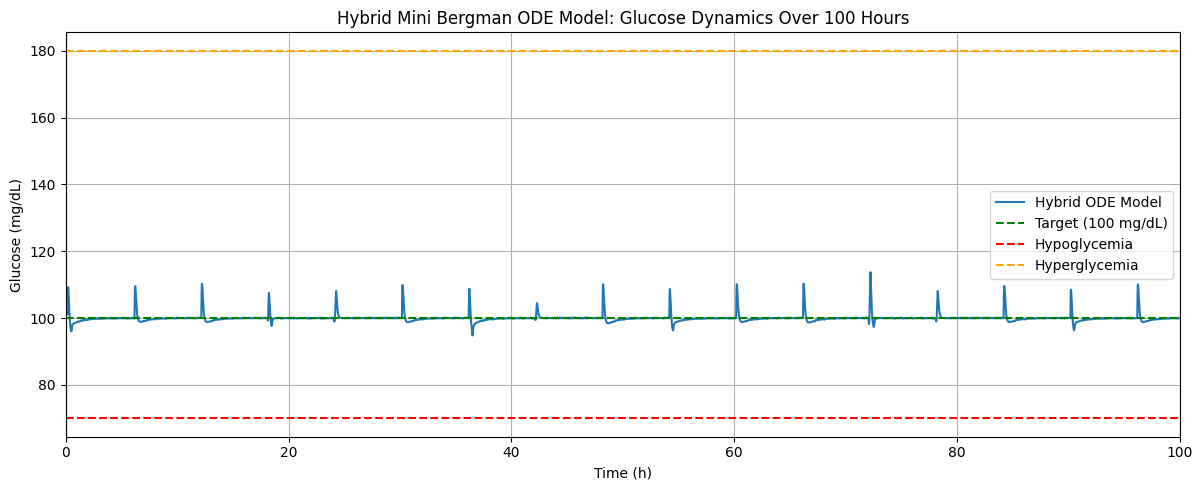

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Simulation parameters ---
hours = 100
t_end = hours * 60  # in minutes
interval = 360  # 6 hours in minutes

# --- Physiological parameters (your exact values) ---
body_weight = 80
initial_glucose = 110
volume_density = 0.2
insulin_sensitivity = 10
k = 8
glucose_target = 100
met = 4
exercise_duration = 20
r = 0.15
p2 = 0.02
ka = 0.3
clearance_decay = 0.01
clearance_time_const = 240
insulin_dose = 1

# Advanced constants for ODE
p1 = 0.01
p3 = 0.0005
n = 0.1
Gb = 100
Ib = 10

# --- Schedule generators ---
def generate_meal_schedule(interval, total_minutes, grams=50):
    return [(t, grams) for t in range(10, total_minutes, interval)]

def generate_exercise_schedule(interval, total_minutes, duration=20, frequency=3):
    return [(t, duration) for i, t in enumerate(range(10, total_minutes, interval)) if i % frequency == 0]

meal_schedule = generate_meal_schedule(interval, t_end)
exercise_schedule = generate_exercise_schedule(interval, t_end, duration=exercise_duration)
injection_times = [m[0] for m in meal_schedule]

# --- Physiological functions ---
def glucose_rise(carbs, k, bw, vd, ka, t):
    dose = (carbs * k) / (bw * vd)
    return dose * ka * np.exp(-ka * t) if t >= 0 else 0

def calories_burned(bw, met, duration):
    return (bw * met * duration) / 60

def energy_expenditure(calories_burned, r):
    return calories_burned * r

def glucose_clearance(g, target, cl_c, step, decay):
    base = ((g - target) / cl_c) * step
    return base * np.exp(-decay * (step / 60))

def insulin_func(t, injection_times, dose):
    return dose if any(start <= t <= start + 1 for start in injection_times) else 0

# --- Hybrid ODE ---
def hybrid_ode(t, y, params, meal_schedule, exercise_schedule, injection_times):
    G, X, I = y
    (p1, p2, p3, n, Gb, Ib, k, bw, vd, ka, cl_c, interval, decay_rate, met, r, dose) = params

    meal_input = sum(glucose_rise(c, k, bw, vd, ka, t - t_m) for t_m, c in meal_schedule if t >= t_m)
    ex_input = sum(energy_expenditure(calories_burned(bw, met, d), r) / d
                   for t_ex, d in exercise_schedule if t_ex <= t <= t_ex + d)
    clearance = glucose_clearance(G, Gb, cl_c * 60, interval * 60, decay_rate)
    u = insulin_func(t, injection_times, dose)

    dGdt = meal_input - X * G - ex_input - clearance
    dXdt = -p2 * X + p3 * (I - Ib)
    dIdt = -n * (I - Ib) + u
    return [dGdt, dXdt, dIdt]

# --- Simulation ---
def simulate_glucose(meal_schedule, exercise_schedule, injection_times, params, t_end):
    y0 = [initial_glucose, 0, params[5]]
    t_span = (0, t_end)
    t_eval = np.arange(0, t_end + 1)
    result = solve_ivp(
        hybrid_ode,
        t_span,
        y0,
        t_eval=t_eval,
        args=(params, meal_schedule, exercise_schedule, injection_times)
    )
    return result.t, result.y[0]

# --- Run simulation ---
params = [p1, p2, p3, n, Gb, Ib, k, body_weight, volume_density, ka,
          clearance_time_const / 60, 1, clearance_decay, met, r, insulin_dose]

t_hybrid, g_hybrid = simulate_glucose(meal_schedule, exercise_schedule, injection_times, params, t_end)

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(t_hybrid / 60, g_hybrid, label="Hybrid ODE Model")
plt.axhline(glucose_target, color='green', linestyle='--', label="Target (100 mg/dL)")
plt.axhline(70, color='red', linestyle='--', label="Hypoglycemia")
plt.axhline(180, color='orange', linestyle='--', label="Hyperglycemia")
plt.title("Hybrid Mini Bergman ODE Model: Glucose Dynamics Over 100 Hours")
plt.xlabel("Time (h)")
plt.ylabel("Glucose (mg/dL)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(0, hours)
plt.show()


In [ ]:
#Grid Search with Discrete Model (no time delay or decay) - it optimize Insulin and keep Carb Intake / time and Exercise constant

# Grid Search
# Given Constants
body_weight = 80  # kg
glucose_level = 150  # mg/dL (current glucose level)
volume_density = 200  # mL/kg (glucose distribution volume)
clearance_time_const = 240  # minutes (clearance rate time constant)
insulin_sensitivity_factor = 20  # mg/dL per unit of insulin
calories_burned_factor = 0.15  # mg/dL per kcal
carbs_intake = 50  # g (grams of carbs consumed)
k = 8  # conversion factor (glucose release per gram of carbs)
glucose_target = 100  # mg/dL (desired glucose level)
time_step = 60  # minutes (1 hour)
met = 4  # metabolic equivalent (exercise intensity factor)
exercise_time = 20  # minutes
r = 0.15  # mg/dL per kcal burned

# Function Definitions
def glucose_rise(carbs, k, bw, vd):
    """ Compute glucose increase from carbohydrate intake """
    return (carbs * k) / (bw * vd)

def glucose_drop(insulin_dose, s):
    """ Compute glucose reduction due to insulin """
    return insulin_dose * s

def calories_burned(bw, met, exercise_time):
    """ Compute calories burned during exercise """
    return (bw * met * exercise_time) / 60

def glucose_clearance(glucose_level, glucose_target, clearance_time_const, time_step):
    """ Compute glucose clearance rate """
    return ((glucose_level - glucose_target) / clearance_time_const) * time_step

def energy_expenditure(calories_burned, r):
    """ Compute glucose reduction from calories burned """
    return calories_burned * r

# Grid search over insulin dose
best_D = None
best_glucose = None
min_error = float('inf')

insulin_doses = [i * 0.5 for i in range(2, 21)]  # Testing doses from 1 to 10 in 0.5 steps

for D in insulin_doses:
    # Compute glucose components
    G_rise = glucose_rise(carbs_intake, k, body_weight, volume_density)
    G_drop = glucose_drop(D, insulin_sensitivity_factor)
    C_burn = calories_burned(body_weight, met, exercise_time)
    G_clear = glucose_clearance(glucose_level, glucose_target, clearance_time_const, time_step)
    G_burn = energy_expenditure(C_burn, r)

    # Compute future glucose level
    G_next = glucose_level + G_rise - G_drop - G_clear - G_burn

    # Compute error from target
    error = abs(G_next - glucose_target)

    # Update best insulin dose
    if error < min_error:
        min_error = error
        best_D = D
        best_glucose = G_next

best_D, best_glucose, min_error


(1.0, 101.525, 1.5250000000000057)

Generation 1: Best = 1910.40, Worst = 3367.95, Avg = 2937.97, Range = 1457.55
Generation 2: Best = 1910.40, Worst = 3353.86, Avg = 2604.93, Range = 1443.46
Generation 3: Best = 1910.40, Worst = 3573.39, Avg = 2256.77, Range = 1662.99
Generation 4: Best = 1910.40, Worst = 3224.51, Avg = 2114.24, Range = 1314.11
Generation 5: Best = 1910.40, Worst = 3273.15, Avg = 2062.33, Range = 1362.74
Generation 6: Best = 1910.40, Worst = 3256.91, Avg = 2064.31, Range = 1346.51
Generation 7: Best = 1910.40, Worst = 3372.70, Avg = 2105.62, Range = 1462.30
Generation 8: Best = 1910.40, Worst = 3238.58, Avg = 2029.23, Range = 1328.18
Generation 9: Best = 1910.40, Worst = 3324.07, Avg = 2136.87, Range = 1413.67
Generation 10: Best = 1910.40, Worst = 3214.21, Avg = 2007.51, Range = 1303.80
Generation 11: Best = 1910.40, Worst = 3055.34, Avg = 1964.79, Range = 1144.94
Generation 12: Best = 1910.40, Worst = 3185.23, Avg = 2021.84, Range = 1274.83
Generation 13: Best = 1910.40, Worst = 3332.77, Avg = 1973.19

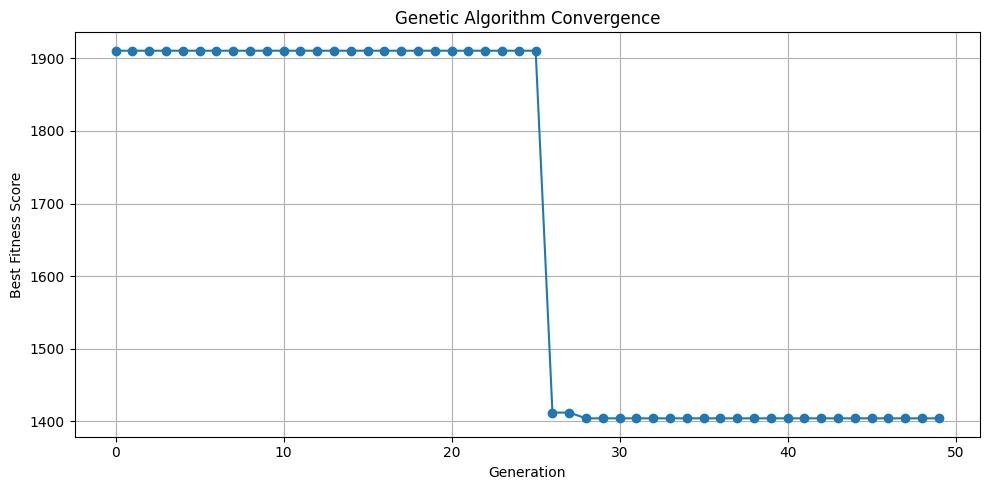

In [ ]:
# GA with Discrete Model (not time delay or decay) - fixed Meal Timing
# 80-130 mg/dL safe range
# No random crossover to preserve relation between Glucose & Insulin
#no seed defined so everytim a new search space - with every new start lands in a different area of the solution space
#power and trade-off evolutionary search


import numpy as np
import random
import matplotlib.pyplot as plt

# === Constants ===
body_weight = 80  # kg
glucose_target = 100  # mg/dL
insulin_sensitivity_factor = 20  # mg/dL per unit of insulin
met = 4  # Metabolic Equivalent Task (exercise intensity)
r = 0.15  # mg/dL per kcal burned
clearance_time_const = 240  # minutes
time_step = 60  # minutes
glucose_decay_rate = 0.05  # Time-based decay (not used here)

meal_times = [0, 6, 12, 18]

# GA Parameters
population_size = 50
generations = 50
mutation_rate = 0.2

# === Core Functions ===
def glucose_rise(carbs, k, bw, vd):
    return (carbs * k) / (bw * vd)

def glucose_drop(insulin_dose, s):
    return insulin_dose * s

def calories_burned(bw, met, exercise_time):
    return (bw * met * exercise_time) / 60

def glucose_clearance(glucose_level, glucose_target, clearance_time_const, time_step):
    return ((glucose_level - glucose_target) / clearance_time_const) * time_step

def energy_expenditure(calories_burned, r):
    return calories_burned * r

# === Fitness Function ===
def compute_fitness(insulin_schedule, carb_schedule, exercise_time, exercise_duration):
    G = 150  # Starting glucose
    total_error = 0

    for i, meal_time in enumerate(meal_times):
        G_rise = glucose_rise(carb_schedule[i], 8, body_weight, 200)
        G_drop = glucose_drop(insulin_schedule[i], insulin_sensitivity_factor)
        C_burn = calories_burned(body_weight, met, exercise_duration)
        G_clear = glucose_clearance(G, glucose_target, clearance_time_const, time_step)
        G_burn = energy_expenditure(C_burn, r)

        G_next = G + G_rise - G_drop - G_clear - G_burn

        # Penalize unsafe glucose ranges
        if G_next < 70 or G_next > 180:
            total_error += 500

        # Accumulate deviation
        total_error += abs(G_next - glucose_target)

        G = G_next  # Update for next step

    return total_error

# === Population Generation ===
def generate_population(size):
    population = []
    for _ in range(size):
        insulin_schedule = [random.uniform(0.5, 10) for _ in meal_times]
        carb_schedule = [random.randint(30, 80) for _ in meal_times]
        exercise_time = random.choice(range(6, 22))
        exercise_duration = random.choice([20, 30, 40, 50, 60])
        population.append((insulin_schedule, carb_schedule, exercise_time, exercise_duration))
    return population

# === Crossover and Mutation ===
def crossover(parent1, parent2):
    insulin = [(p1 + p2) / 2 for p1, p2 in zip(parent1[0], parent2[0])]
    carbs = [(c1 + c2) // 2 for c1, c2 in zip(parent1[1], parent2[1])]
    exercise_time = int((parent1[2] + parent2[2]) / 2)
    exercise_duration = int((parent1[3] + parent2[3]) / 2)
    return (insulin, carbs, exercise_time, exercise_duration)

def mutate(individual):
    return generate_population(1)[0]

# === Genetic Algorithm ===
def genetic_algorithm():
    population = generate_population(population_size)
    best_fitness_per_generation = []

    for generation in range(generations):
        fitness_scores = [(compute_fitness(*individual), individual) for individual in population]
        fitness_scores.sort(key=lambda x: x[0])

        fitness_values = [score for score, _ in fitness_scores]
        best = fitness_values[0]
        worst = fitness_values[-1]
        avg = sum(fitness_values) / len(fitness_values)
        range_fitness = worst - best

        best_fitness_per_generation.append(best)

        print(f"Generation {generation+1}: Best = {best:.2f}, Worst = {worst:.2f}, Avg = {avg:.2f}, Range = {range_fitness:.2f}")

        # Elitism
        best_individuals = [ind[1] for ind in fitness_scores[:10]]
        new_population = best_individuals[:]

        while len(new_population) < population_size:
            parent1, parent2 = random.sample(best_individuals, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                child = mutate(child)
            new_population.append(child)

        population = new_population

    best_solution = min(population, key=lambda ind: compute_fitness(*ind))
    return best_solution, best_fitness_per_generation

# === Run GA ===
best_solution, best_fitness_per_generation = genetic_algorithm()
best_fitness = compute_fitness(*best_solution)

# === Print Best Result ===
print("="*60)
print(f"Best Fitness Score (Total Glucose Deviation): {best_fitness:.2f}")
print("Optimal Solution Found:")
print(f"  Insulin Doses (U):        {[round(i, 2) for i in best_solution[0]]}")
print(f"  Carbohydrates (g):        {best_solution[1]}")
print(f"  Exercise Time (hour):     {best_solution[2]}")
print(f"  Exercise Duration (min):  {best_solution[3]}")
print("="*60)

# === Plot Convergence ===
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_per_generation, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()



Running GA Round 1 of 5
Generation 1: Best = 2041.79, Worst = 3418.82, Avg = 2865.47, Range = 1377.02
Generation 2: Best = 2041.79, Worst = 3311.92, Avg = 2337.80, Range = 1270.13
Generation 3: Best = 2041.79, Worst = 3571.51, Avg = 2276.54, Range = 1529.71
Generation 4: Best = 2041.79, Worst = 3382.78, Avg = 2200.52, Range = 1340.98
Generation 5: Best = 2039.80, Worst = 3500.86, Avg = 2155.33, Range = 1461.06
Generation 6: Best = 2037.68, Worst = 3229.18, Avg = 2228.09, Range = 1191.50
Generation 7: Best = 2035.62, Worst = 3280.42, Avg = 2273.10, Range = 1244.80
Generation 8: Best = 2035.62, Worst = 3234.72, Avg = 2167.92, Range = 1199.10
Generation 9: Best = 2027.10, Worst = 3267.80, Avg = 2146.11, Range = 1240.71
Generation 10: Best = 2027.10, Worst = 3282.63, Avg = 2165.48, Range = 1255.54
Generation 11: Best = 2026.11, Worst = 3140.86, Avg = 2208.77, Range = 1114.75
Generation 12: Best = 2025.12, Worst = 3104.15, Avg = 2103.08, Range = 1079.02
Generation 13: Best = 2025.12, Worst

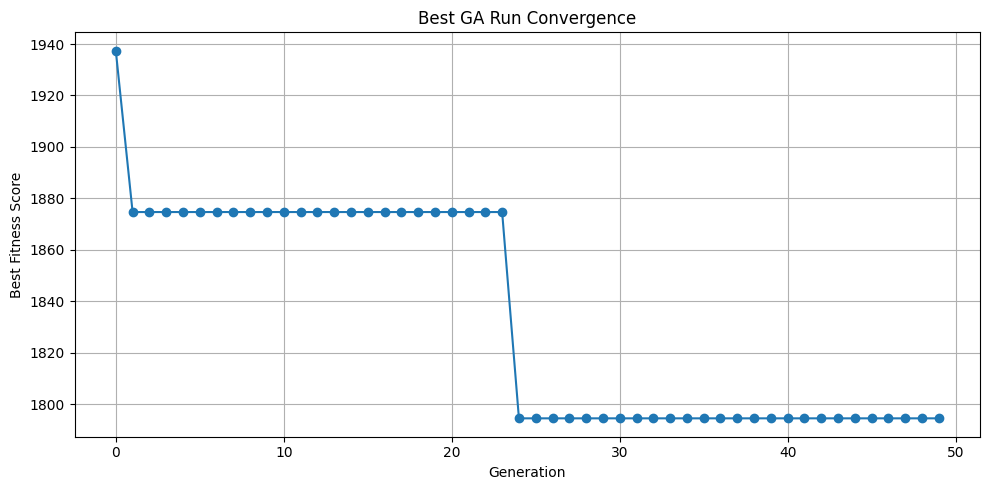

In [ ]:
# Genetic Algorithm with Discrete Glucose-Insulin Model
# - Preserves insulin-carb relationship
# - Runs GA multiple times to explore wider search space
# safes from all run the best plan

import numpy as np
import random
import matplotlib.pyplot as plt

# === Constants ===
body_weight = 80  # kg
glucose_target = 100  # mg/dL
insulin_sensitivity_factor = 20  # mg/dL per unit of insulin
met = 4  # MET
r = 0.15  # mg/dL per kcal burned
clearance_time_const = 240  # minutes
time_step = 60  # minutes
meal_times = [0, 6, 12, 18]  # fixed meal times

# Genetic Algorithm Parameters
population_size = 50
generations = 50
mutation_rate = 0.2

# === Glucose Response Functions ===
def glucose_rise(carbs, k, bw, vd):
    return (carbs * k) / (bw * vd)

def glucose_drop(insulin_dose, s):
    return insulin_dose * s

def calories_burned(bw, met, exercise_time):
    return (bw * met * exercise_time) / 60

def glucose_clearance(glucose_level, glucose_target, clearance_time_const, time_step):
    return ((glucose_level - glucose_target) / clearance_time_const) * time_step

def energy_expenditure(calories_burned, r):
    return calories_burned * r

# === Fitness Function ===
def compute_fitness(insulin_schedule, carb_schedule, exercise_time, exercise_duration):
    G = 150  # starting glucose
    total_error = 0

    for i, meal_time in enumerate(meal_times):
        G_rise = glucose_rise(carb_schedule[i], 8, body_weight, 200)
        G_drop = glucose_drop(insulin_schedule[i], insulin_sensitivity_factor)
        C_burn = calories_burned(body_weight, met, exercise_duration)
        G_clear = glucose_clearance(G, glucose_target, clearance_time_const, time_step)
        G_burn = energy_expenditure(C_burn, r)

        G_next = G + G_rise - G_drop - G_clear - G_burn

        if G_next < 70 or G_next > 180:
            total_error += 500  # penalty for unsafe glucose

        total_error += abs(G_next - glucose_target)
        G = G_next

    return total_error

# === Population Utilities ===
def generate_population(size):
    population = []
    for _ in range(size):
        insulin_schedule = [random.uniform(0.5, 10) for _ in meal_times]
        carb_schedule = [random.randint(30, 80) for _ in meal_times]
        exercise_time = random.choice(range(6, 22))
        exercise_duration = random.choice([20, 30, 40, 50, 60])
        population.append((insulin_schedule, carb_schedule, exercise_time, exercise_duration))
    return population

def crossover(parent1, parent2):
    insulin = [(p1 + p2) / 2 for p1, p2 in zip(parent1[0], parent2[0])]
    carbs = [(c1 + c2) // 2 for c1, c2 in zip(parent1[1], parent2[1])]
    exercise_time = int((parent1[2] + parent2[2]) / 2)
    exercise_duration = int((parent1[3] + parent2[3]) / 2)
    return (insulin, carbs, exercise_time, exercise_duration)

def mutate(individual):
    return generate_population(1)[0]

# === Core Genetic Algorithm ===
def genetic_algorithm():
    population = generate_population(population_size)
    best_fitness_per_generation = []

    for generation in range(generations):
        fitness_scores = [(compute_fitness(*ind), ind) for ind in population]
        fitness_scores.sort(key=lambda x: x[0])

        best = fitness_scores[0][0]
        worst = fitness_scores[-1][0]
        avg = sum(score for score, _ in fitness_scores) / len(fitness_scores)
        range_fitness = worst - best
        best_fitness_per_generation.append(best)

        print(f"Generation {generation+1}: Best = {best:.2f}, Worst = {worst:.2f}, Avg = {avg:.2f}, Range = {range_fitness:.2f}")

        # Elitism
        best_individuals = [ind[1] for ind in fitness_scores[:10]]
        new_population = best_individuals[:]

        while len(new_population) < population_size:
            parent1, parent2 = random.sample(best_individuals, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                child = mutate(child)
            new_population.append(child)

        population = new_population

    best_solution = min(population, key=lambda ind: compute_fitness(*ind))
    return best_solution, best_fitness_per_generation

# === Run GA Multiple Times and Track Best ===
def run_multiple_GAs(n_runs=5):
    all_runs = []

    for i in range(n_runs):
        print(f"\nRunning GA Round {i+1} of {n_runs}")
        best_solution, fitness_trace = genetic_algorithm()
        score = compute_fitness(*best_solution)
        all_runs.append((score, best_solution, fitness_trace))

    best_overall = min(all_runs, key=lambda x: x[0])
    return best_overall

# === Execute and Display Results ===
best_fitness, best_solution, best_fitness_trace = run_multiple_GAs(n_runs=5)

print("\n" + "="*60)
print(f"Best Fitness Score Across All Runs: {best_fitness:.2f}")
print("Optimal Solution Found:")
print(f"  Insulin Doses (U):        {[round(i, 2) for i in best_solution[0]]}")
print(f"  Carbohydrates (g):        {best_solution[1]}")
print(f"  Exercise Time (hour):     {best_solution[2]}")
print(f"  Exercise Duration (min):  {best_solution[3]}")
print("="*60)

# === Plot Fitness Convergence for Best Run ===
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_trace, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.title("Best GA Run Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


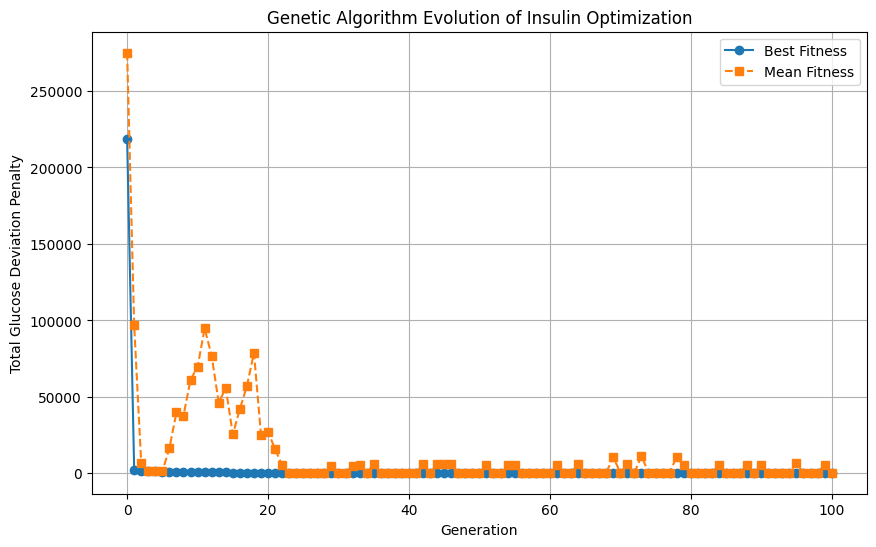

Best Insulin Plan:  [np.float64(4.4909056935470675), np.float64(5.81031587551036), np.float64(6.093847391500605), np.float64(5.102219060444924), np.float64(3.3770394425320207), np.float64(6.005506116488661), np.float64(3.098111392690707), np.float64(6.023005307316744), np.float64(4.1258049302887025), np.float64(4.3786224279282), np.float64(5.604793480558351), np.float64(5.539697804253563), np.float64(3.123761103832905), np.float64(4.131886889160233), np.float64(5.5851830191168546), np.float64(3.536785137408309), np.float64(5.50740601840528), np.float64(4.096154529589699), np.float64(5.516970664888676), np.float64(7.816110684755175), np.float64(3.7540203857912786), np.float64(5.209357119697911), np.float64(4.683461769939384), np.float64(4.3189937191963494), np.float64(4.232319217609566), np.float64(4.759844876570898), np.float64(5.857175266280013), np.float64(3.7086269859876264), np.float64(3.8280566489398407), np.float64(2.922621047404513), np.float64(6.71870038119652), np.float64(6.61

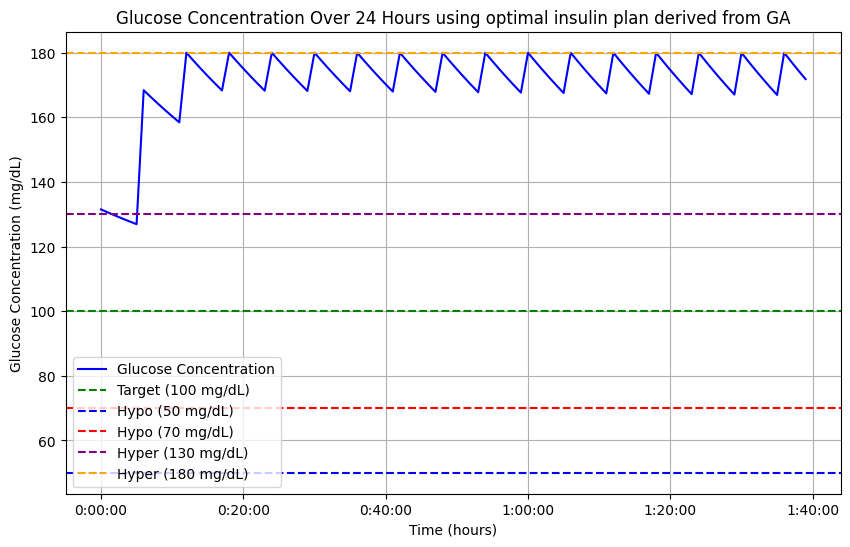

Best Insulin Plan:  [np.float64(4.4909056935470675), np.float64(5.81031587551036), np.float64(6.093847391500605), np.float64(5.102219060444924), np.float64(3.3770394425320207), np.float64(6.005506116488661), np.float64(3.098111392690707), np.float64(6.023005307316744), np.float64(4.1258049302887025), np.float64(4.3786224279282), np.float64(5.604793480558351), np.float64(5.539697804253563), np.float64(3.123761103832905), np.float64(4.131886889160233), np.float64(5.5851830191168546), np.float64(3.536785137408309), np.float64(5.50740601840528), np.float64(4.096154529589699), np.float64(5.516970664888676), np.float64(7.816110684755175), np.float64(3.7540203857912786), np.float64(5.209357119697911), np.float64(4.683461769939384), np.float64(4.3189937191963494), np.float64(4.232319217609566), np.float64(4.759844876570898), np.float64(5.857175266280013), np.float64(3.7086269859876264), np.float64(3.8280566489398407), np.float64(2.922621047404513), np.float64(6.71870038119652), np.float64(6.61

In [ ]:
#GA with Deap libary
!pip install deap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from deap import base, creator, tools, algorithms
import datetime

# keep deviation as low as possible from the target glucose level (100 mg/dL)

G_TARGET = 100  # Target glucose level (mg/dL)
G_MIN = 70  # Minimum glucose level (mg/dL)
G_MAX = 130  # Maximum glucose level (mg/dL)
G_CRIT_MAX = 180  # Critical glucose level (mg/dL)
G_CRIT_MIN = 50  # Critical glucose level (mg/dL)


# ---------------------------
# 1. Minimal Bergman Model
# ---------------------------
class MinimalBergmanModel:
    def __init__(self, Gb=145, Ib=10, k1=0.03082, k2=0.03093, k3=1.062 * 1e-6):
        self.G = Gb  # Initial glucose concentration (mg/dL)
        self.Gb = Gb # Baseline glucose concentration (mg/dL)
        self.I = Ib  # Blood insulin concentration (mU/L)
        self.Ib = Ib # Baseline insulin concentration (mU/L)
        self.X = 0   # The effect of active insulin (1/min)
        self.k1 = k1 # Insulin independent glucose clearance rate (1/min)
        self.k2 = k2 # Active insulin clearance rat e (1/min)
        self.k3 = k3 # Increase in uptake ability caused by insulin (L/(mU*min^2))

        self.dt = 1  # Time step (min)

    def update(self, insulin_input, glucose_input, glucose_clearance):
        dG = -self.k1 * (self.G - self.Gb) - self.X * self.G + glucose_input - glucose_clearance
        dX = self.k3 * (self.I - self.Ib) - self.k2 * self.X # insulin in tissue
        dI = insulin_input # in blood after injection

        self.G += dG * self.dt
        self.X += dX * self.dt
        self.I += dI * self.dt

        self.G = np.clip(self.G, G_CRIT_MIN, G_CRIT_MAX)  # Glucose limits

        return self.G


# ---------------------------
# 2. Enhanced Physiological Model
# ---------------------------
class DiabetesModel:
    def __init__(self, bw = 80 , vd = 200, k = 8, s = 20, r = 0.15):
        self.bw = bw          # Body weight (kg)
        self.vd = vd          # Volume density (dL/kg)
        self.k = k            # Carb-to-glucose factor (mg/dL per g)
        self.s = s            # Insulin sensitivity (mg/dL/unit)
        self.r = r            # Exercise impact (mg/dL per kcal)
        self.met = 4          # MET value
        self.dt = 1           # Time step (min) update model every minute
        self.glucose = 100    # Initial glucose (mg/dL)
        self.insulin = 10      # Plasma insulin (mU/dL)
        self.G_target = G_TARGET   # Target glucose (mg/dL)
        self.F = 0            # Fitness score
        self.bergman = MinimalBergmanModel(Gb=self.glucose, Ib=self.insulin)  # Integrate Bergman Model
        self.Gt = []  # Glucose levels over time

    def update(self, carb, insulin_dose, exercise_min, T):
        for t in T:
            G_rise = (self.k * carb[t]) / (self.vd * self.bw) * 60 *15 # Glucose rise from carbs
            G_fall = (self.r * self.met * exercise_min[t])   # Glucose clearance from exercise
            self.glucose = self.bergman.update(insulin_dose[t], G_rise, G_fall)  # Bergman model update with our model (G_rise and G_fall)
            self.glucose = np.clip(self.glucose, G_CRIT_MIN, G_CRIT_MAX)  # Glucose limits
            self.Gt.append(self.glucose)  # Store glucose levels for plotting
            self.F += abs(self.glucose - self.G_target)**2  # Fitness score (sum of squared deviations from target)

        return self.F



CARB_MIN = 50
CARB_MAX = 100

MEAL_DURATION = 15  # minutes

INSULIN_MIN = 0.5
INSULIN_MAX = 10.0
HOUR_UNIT = 60
TIME =100 * HOUR_UNIT  # 24 hours in minutes

DOSES_PER_DAY = 4  # Number of insulin doses per day
TOTAL_DOSES = TIME // HOUR_UNIT * DOSES_PER_DAY  # Total doses

EXERCISE_TIME = 19 # 7 PM

# ---------------------------
# 3. Genetic Algorithm Setup
# ---------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize the individual with random insulin doses
# Each individual represents an insulin plan for 24 hours (4 doses)
def init_individual(icls):
    return icls(np.random.uniform(INSULIN_MIN, INSULIN_MAX, TOTAL_DOSES))

toolbox = base.Toolbox()
toolbox.register("individual", init_individual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



# ---------------------------
# 4. Fitness Function (24-hours Simulation)
# ---------------------------
def evaluate(individual):
    model = DiabetesModel()
    total_penalty = 0

    # C,D,E store the meal, insulin doses and exercise time respectively for every minute in 24 hours
    # We initialize them to 0 for every minute in 24 hours and then set the values for the meal, insulin doses and exercise time
    C = {t: 0 for t in range(TIME)}
    D = {t: 0 for t in range(TIME)}
    E = {t: 0 for t in range(TIME)}

    # The individual eats at 6,12,18 and 24. And all meals take a duration of MEAL_DURATION so the glucose level will rise gradually over the meal duration.
    for t in range(6 * HOUR_UNIT,TIME,6 * HOUR_UNIT):
        carbs = np.random.randint(CARB_MIN, CARB_MAX)
        for s in range(MEAL_DURATION):
            C[t+s] = carbs / MEAL_DURATION  # Distribute carbs over meal duration  (every minute of the meal will have the same amount of carbs 1 spoon = 15g of carbs)

    # C[6 * HOUR_UNIT] = np.random.randint(CARB_MIN, CARB_MAX) # Random carb for 6 AM
    # C[12 * HOUR_UNIT] = np.random.randint(CARB_MIN, CARB_MAX) # Random carb for 12 PM
    # C[18 * HOUR_UNIT] = np.random.randint(CARB_MIN, CARB_MAX) # Random carb for 6 PM
    # C[24 * HOUR_UNIT] = np.random.randint(CARB_MIN, CARB_MAX) # Random carb for 12 AM

    for t in range(6 * HOUR_UNIT,TIME,6 * HOUR_UNIT):
        D[t] = individual[t // HOUR_UNIT] # Insulin doses for 6 AM, 12 PM, 6 PM and 12 AM (every 6 hours)
    # D[6 * HOUR_UNIT] = individual[0] # Insulin doses for 6 AM takes 1 minute to take effect(injection)
    # D[12 * HOUR_UNIT] = individual[1] # Insulin doses for 12 PM
    # D[18 * HOUR_UNIT] = individual[2] # Insulin doses for 6 PM
    # D[24 * HOUR_UNIT] = individual[3] # Insulin doses for 12 AM

    for t in range(EXERCISE_TIME * HOUR_UNIT,TIME, 24 * HOUR_UNIT):
        exercise_time = np.random.randint(0, 30)
        for s in range(exercise_time):
            E[t + s] = 1 # 1 minute of exercise otherwise 0 defined above
    total_penalty = model.update(C, D, E, range(TIME))

    return (total_penalty,)

# make sure the individual is feasible (inside the insulin limits)
def feasible(individual):
    return all(INSULIN_MIN <= dose <= INSULIN_MAX for dose in individual)

# penalty for infeasible individuals (deviation from the feasible region)
def distance(individual):
    """A distance function to the feasibility region."""
    return sum((dose - 5.0)**2 for dose in individual)

toolbox.register("evaluate", evaluate) # fitness function
# register the constraint functions with the toolbox
toolbox.decorate("evaluate", tools.DeltaPenality( feasible, 7.0, distance)) # penalty for infeasible individuals (deviation from the feasible region)
toolbox.register("mate", tools.cxBlend, alpha=0.2)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1) # Gaussian mutation
toolbox.register("select", tools.selTournament, tournsize=3) # Tournament selection



# ---------------------------
# 5. Run GA and Plot Results
# ---------------------------

""" plot deviation penalty over generations in GA algorithm
    For each generation of individuals, we will plot the best and mean fitness values
    (the deviation penalty) for the individuals insulin doses and the glucose levels deviations from the target.
    The x-axis will be the generation number and the y-axis will be the deviation penalty.
"""
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("min", np.min)
stats.register("mean", np.mean)

population, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=100,
    stats=stats, halloffame=hof, verbose=False
)
# Plot convergence
plt.figure(figsize=(10, 6))
generations = logbook.select("gen")
min_fitness = logbook.select("min")
mean_fitness = logbook.select("mean")
plt.plot(generations, min_fitness, marker='o', linestyle='-', label='Best Fitness')
plt.plot(generations, mean_fitness, marker='s', linestyle='--', label='Mean Fitness')
plt.xlabel("Generation")
plt.ylabel("Total Glucose Deviation Penalty")
plt.title("Genetic Algorithm Evolution of Insulin Optimization")
plt.legend()
plt.grid(True)
plt.show()

# After running the GA, we can print the best insulin plan found (this plan should work for all individuals that follow a similar plan for 24 hours)
print("Best Insulin Plan: ", hof[0])
# ---------------------------
# 6. Analyze Best Insulin Plan
# ---------------------------

"""Create a random meal plan for 24 hours and simulate the glucose levels using the best insulin plan found by the GA."""
# best_insulin = hof[0]

# Gt = []
# model = DiabetesModel()


# C = {t: 0 for t in range(TIME)}
# D = {t: 0 for t in range(TIME)}
# E = {t: 0 for t in range(TIME)}



# for t in range(6 * HOUR_UNIT,TIME,6 * HOUR_UNIT):
#         carbs = np.random.randint(CARB_MIN, CARB_MAX)
#         for s in range(MEAL_DURATION):
#             C[t+s] = carbs / MEAL_DURATION



# for t in range(6 * HOUR_UNIT,TIME,6 * HOUR_UNIT):
#         D[t] = best_insulin[t // HOUR_UNIT] # Insulin doses for 6 AM, 12 PM, 6 PM and 12 AM (every 6 hours)

# for t in range(EXERCISE_TIME * HOUR_UNIT,TIME, 24 * HOUR_UNIT):
#     exercise_time = np.random.randint(0, 30)
#     for s in range(exercise_time):
#         E[t + s] = 1 # 1 minute of exercise otherwise 0 defined above

# model.update(C, D, E, range(TIME))
# Gt = model.Gt

best_insulin = hof[0]

Gt = []
model = DiabetesModel()

# Time is now calculated for each hour over 100 hours
TIME = 100  # Total time in hours

C = {t: 0 for t in range(TIME)}
D = {t: 0 for t in range(TIME)}
E = {t: 0 for t in range(TIME)}

# Define Carb Intake (Meals) - Now each hour instead of every minute
for t in range(0, TIME, 6):  # Meals every 6 hours (e.g., 6 AM, 12 PM, 6 PM, 12 AM)
    carbs = np.random.randint(CARB_MIN, CARB_MAX)
    C[t] = carbs  # All carbs consumed at the start of the hour

# Apply Best Insulin Plan (Every 6 hours)
for t in range(0, TIME, 6):
    D[t] = best_insulin[t // 6]  # Insulin doses applied at 6-hour intervals

# Simulate Exercise - Once per day (7 PM = 19th hour of the day)
for t in range(EXERCISE_TIME, TIME, 24):
    exercise_duration = np.random.randint(0, 1)  # Now a single value per hour (0 or 1)
    E[t] = exercise_duration  # Mark exercise as happening for that hour (0 or 1)

# Update model with the modified dictionaries
model.update(C, D, E, range(TIME))
Gt = model.Gt  # Store the glucose levels after simulation



fig = plt.figure(figsize=(10, 6))
plt.plot(range(TIME), Gt, label="Glucose Concentration", color='blue')
def timeTicks(x, pos):
    d = datetime.timedelta(minutes=x)
    return str(d)
formatter = matplotlib.ticker.FuncFormatter(timeTicks)
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
plt.xlabel("Time (hours)")
plt.ylabel("Glucose Concentration (mg/dL)")
plt.title("Glucose Concentration Over 24 Hours using optimal insulin plan derived from GA")
plt.axhline(y=G_TARGET, color='green', linestyle='--', label='Target (100 mg/dL)')
plt.axhline(y=G_CRIT_MIN, color='blue', linestyle='--', label='Hypo (50 mg/dL)')
plt.axhline(y=G_MIN, color='red', linestyle='--', label='Hypo (70 mg/dL)')
plt.axhline(y=G_MAX, color='purple', linestyle='--', label='Hyper (130 mg/dL)')
plt.axhline(y=G_CRIT_MAX, color='orange', linestyle='--', label='Hyper (180 mg/dL)')

plt.legend()
plt.grid(True)
plt.show()

print("Best Insulin Plan: ", best_insulin)
print("Meal Plan: ", [C[t] for t in range(TIME) if C[t] > 0])
print("Exercise Plan: ", sum([E[t] for t in range(TIME) if E[t] > 0]), "Minutes")
print("Glucose Levels: ", Gt)


GA completed in 148.47 seconds
Total combinations explored: 5000
Best Deviation Score (with Penalties): 439.88

Best Meal Plan (Optimized):
Meal 1: Time = 111 min, Carbs = 58 g
Meal 2: Time = 651 min, Carbs = 36 g
Meal 3: Time = 1270 min, Carbs = 30 g

Insulin Plan:
Injection 1: Time = 324 min, Dose = 3.2 units
Injection 2: Time = 413 min, Dose = 8.8 units
Injection 3: Time = 1224 min, Dose = 2.3 units

 Exercise Plan:
Start = 868 min, Duration = 13 min, MET = 2.3


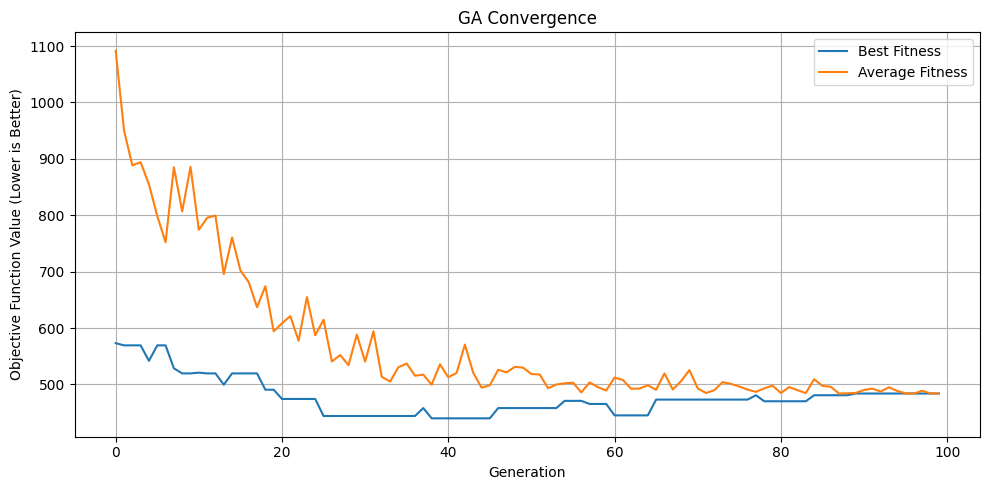

In [ ]:
#GA Experiment

# ------------------------------------------------------------
# HYBRID MINI BERGMAN ODE MODEL + GENETIC ALGORITHM OPTIMIZATION
# WITH HYPER/HYPOGLYCEMIA PENALTIES, CONVERGENCE PLOTTING, ELITISM,
# TWO-POINT CROSSOVER, AND ADAPTIVE MUTATION RATE
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
import time

# ------------------------------------------------------------
# AVATAR PROFILE
# ------------------------------------------------------------
class Avatar:
    def __init__(self,
                 body_weight=80,
                 initial_glucose=150,
                 volume_density=0.2,
                 insulin_sensitivity=10,
                 k=8,
                 glucose_target=100,
                 met=4,
                 exercise_duration=20,
                 r=0.15,
                 p2=0.02,
                 ka=0.3,
                 clearance_decay=0.01,
                 clearance_time_const=240,
                 insulin_dose=4,
                 hypo_threshold=70,
                 hyper_threshold=180):

        self.body_weight = body_weight
        self.initial_glucose = initial_glucose
        self.volume_density = volume_density
        self.insulin_sensitivity = insulin_sensitivity
        self.k = k
        self.glucose_target = glucose_target
        self.met = met
        self.exercise_duration = exercise_duration
        self.r = r
        self.p2 = p2
        self.ka = ka
        self.clearance_decay = clearance_decay
        self.clearance_time_const = clearance_time_const
        self.insulin_dose = insulin_dose
        self.hypo_threshold = hypo_threshold
        self.hyper_threshold = hyper_threshold

avatar = Avatar()

# ------------------------------------------------------------
# PHYSIOLOGICAL MODEL FUNCTIONS (Hybrid Mini Bergman ODE)
# ------------------------------------------------------------
p3 = 0.0005
n = 0.1
Gb = 100
Ib = 10

def glucose_rise(carbs, k, bw, vd, ka, t):
    dose = (carbs * k) / (bw * vd)
    return dose * ka * np.exp(-ka * t) if t >= 0 else 0

def calories_burned(bw, met, duration):
    return (bw * met * duration) / 60

def energy_expenditure(calories, r):
    return calories * r

def glucose_clearance(glucose_level, glucose_target, clearance_const, time_step, decay_rate):
    """
    Simplified glucose clearance without explicit time decay.
    """
    return ((glucose_level - glucose_target) / clearance_const) * time_step

def insulin_func(t, injection_times, doses):
    return sum(dose for start, dose in zip(injection_times, doses) if start <= t <= start + 1)

def hybrid_ode(t, y, params, meal_schedule, exercise_schedule, injection_times, injection_doses):
    G, X, I = y
    (p1, p2, p3, n, Gb, Ib, k, bw, vd, ka, cl_c, interval, decay_rate, r) = params

    meal_input = sum(glucose_rise(c, k, bw, vd, ka, t - t_m) for t_m, c in meal_schedule if t >= t_m)
    ex_input = sum(energy_expenditure(calories_burned(bw, met, d), r) / d
                   for t_ex, d, met in exercise_schedule if t_ex <= t <= t_ex + d)
    clearance = glucose_clearance(G, Gb, cl_c * 60, interval * 60, decay_rate)
    u = insulin_func(t, injection_times, injection_doses)

    return [meal_input - X * G - ex_input - clearance,
            -p2 * X + p3 * (I - Ib),
            -n * (I - Ib) + u]

def simulate_glucose(meals, exercise, insulin_times, insulin_doses, params, t_end):
    y0 = [avatar.initial_glucose, 0, Ib]
    t_span = (0, t_end)
    t_eval = np.arange(0, t_end + 1)

    result = solve_ivp(
        hybrid_ode,
        t_span,
        y0,
        t_eval=t_eval,
        args=(params, meals, exercise, insulin_times, insulin_doses)
    )
    return result.t, result.y[0]

def objective_function(glucose_levels, target, hypo_threshold, hyper_threshold):
    deviation_penalty = np.sum(np.abs(glucose_levels - target))
    hypo_penalty = np.sum(np.maximum(hypo_threshold - glucose_levels, 0)) * 10  # Penalize each mg/dL below hypo
    hyper_penalty = np.sum(np.maximum(glucose_levels - hyper_threshold, 0)) * 5   # Penalize each mg/dL above hyper
    return deviation_penalty + hypo_penalty + hyper_penalty

def rem_deviation(glucose, target):
    return np.sqrt(np.mean((glucose - target) ** 2))

# ------------------------------------------------------------
# GENETIC ALGORITHM CONFIGURATION
# ------------------------------------------------------------
def run_ga(
    t_end=1440,
    meal_time_ranges=[(0, 400), (400, 800), (800, 1300)],
    meal_carb_ranges=[(30, 100), (30, 100), (30, 100)],
    insulin_time_ranges=[(0, 400), (400, 800), (800, 1300)],
    insulin_dose_ranges=[(2, 10), (2, 10), (2, 10)],
    exercise_time_range=(600, 1200),
    exercise_duration_range=(10, 60),
    exercise_intensity_range=(2, 8),
    pop_size=30,
    generations=20,
    mutation_rate_initial=0.5,
    mutation_rate_final=0.05,
    elite_size=2,
    crossover_rate=0.8,
    seed=None
):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    gene_length = 15

    def random_gene():
        return [
            *(random.randint(*r) for r in meal_time_ranges),
            *(random.randint(*r) for r in meal_carb_ranges),
            *(random.randint(*r) for r in insulin_time_ranges),
            *(round(random.uniform(*r), 1) for r in insulin_dose_ranges),
            random.randint(*exercise_time_range),
            random.randint(*exercise_duration_range),
            round(random.uniform(*exercise_intensity_range), 1)
        ]

    def fitness(gene):
        meals = [(gene[0], gene[3]), (gene[1], gene[4]), (gene[2], gene[5])]
        insulins = gene[6:9]
        doses = gene[9:12]
        exercise = [(gene[12], gene[13], gene[14])]

        param_set = [0.01, avatar.p2, p3, n, Gb, Ib, avatar.k, avatar.body_weight,
                     avatar.volume_density, avatar.ka, avatar.clearance_time_const / 60, 1,
                     avatar.clearance_decay, avatar.r]

        t, glucose = simulate_glucose(meals, exercise, insulins, doses, param_set, t_end)
        return objective_function(glucose, avatar.glucose_target, avatar.hypo_threshold, avatar.hyper_threshold)

    population = [random_gene() for _ in range(pop_size)]
    best_gene, best_score = None, float('inf')
    top_solutions = []
    best_fitness_history = []
    avg_fitness_history = []
    start = time.time()

    for gen in range(generations):
        scored = sorted([(fitness(g), g) for g in population])
        best_fitness_history.append(scored[0][0])
        avg_fitness_history.append(np.mean([s[0] for s in scored]))

        # ELITISM
        elite = [g for _, g in scored[:elite_size]]
        remaining_population = [g for _, g in scored[elite_size:pop_size // 2]]
        offspring = elite[:]

        # TWO-POINT CROSSOVER
        while len(offspring) < pop_size - elite_size:
            if random.random() < crossover_rate and len(remaining_population) > 1:
                parent1, parent2 = random.sample(remaining_population, 2)
                child1, child2 = parent1[:], parent2[:]
                pt1 = random.randint(0, gene_length - 1)
                pt2 = random.randint(0, gene_length - 1)
                if pt1 > pt2:
                    pt1, pt2 = pt2, pt1
                child1[pt1:pt2 + 1], child2[pt1:pt2 + 1] = parent2[pt1:pt2 + 1], parent1[pt1:pt2 + 1]
                offspring.append(child1)
                if len(offspring) < pop_size - elite_size:
                    offspring.append(child2)
            else:
                offspring.append(random.choice(remaining_population)) # Reproduction without crossover

        # ADAPTIVE MUTATION
        mutation_rate = mutation_rate_initial - (gen / (generations - 1)) * (mutation_rate_initial - mutation_rate_final)
        mutated_offspring = []
        for individual in offspring:
            mutated_individual = list(individual)
            if random.random() < mutation_rate:
                idx = random.randint(0, gene_length - 1)
                if idx < 3:
                    mutated_individual[idx] = random.randint(*meal_time_ranges[idx])
                elif idx < 6:
                    mutated_individual[idx] = random.randint(*meal_carb_ranges[idx - 3])
                elif idx < 9:
                    mutated_individual[idx] = random.randint(*insulin_time_ranges[idx - 6])
                elif idx < 12:
                    mutated_individual[idx] = round(random.uniform(*insulin_dose_ranges[idx - 9]), 1)
                elif idx == 12:
                    mutated_individual[idx] = random.randint(*exercise_time_range)
                elif idx == 13:
                    mutated_individual[idx] = random.randint(*exercise_duration_range)
                else:
                    mutated_individual[idx] = round(random.uniform(*exercise_intensity_range), 1)
            mutated_offspring.append(mutated_individual)

        population = mutated_offspring

        if scored[0][0] < best_score:
            best_score = scored[0][0]
            best_gene = scored[0][1]

        top_solutions = scored[:3]

    print(f"GA completed in {time.time() - start:.2f} seconds")
    print(f"Total combinations explored: {pop_size * generations}")
    print(f"Best Deviation Score (with Penalties): {best_score:.2f}")

    return best_gene, best_score, top_solutions, best_fitness_history, avg_fitness_history

# ------------------------------------------------------------
# RUN GA + PLOT
# ------------------------------------------------------------
best_gene, best_score, top3, best_fit, avg_fit = run_ga(
    generations=100,  # Increased number of generations
    pop_size=50,     # Increased population size
    mutation_rate_initial=0.5,
    mutation_rate_final=0.01,
    elite_size=5,
    crossover_rate=0.8,
    seed=42
)

# Decode best gene into components
meal_plan = [(best_gene[0], best_gene[3]), (best_gene[1], best_gene[4]), (best_gene[2], best_gene[5])]
insulin_plan = list(zip(best_gene[6:9], best_gene[9:12]))
exercise_plan = [(best_gene[12], best_gene[13], best_gene[14])]

# Print the best meal plan only
print("\nBest Meal Plan (Optimized):")
for i, (time, carbs) in enumerate(meal_plan, 1):
    print(f"Meal {i}: Time = {time} min, Carbs = {carbs} g")

print("\nInsulin Plan:")
for i, (time, dose) in enumerate(insulin_plan, 1):
    print(f"Injection {i}: Time = {time} min, Dose = {dose} units")

print("\n Exercise Plan:")
et, dur, intensity = exercise_plan[0]
print(f"Start = {et} min, Duration = {dur} min, MET = {intensity}")



# Plotting convergence
plt.figure(figsize=(10, 5))
plt.plot(range(len(best_fit)), best_fit, label='Best Fitness')
plt.plot(range(len(avg_fit)), avg_fit, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Objective Function Value (Lower is Better)')
plt.title('GA Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# GA Experiment

# ------------------------------------------------------------
# HYBRID MINI BERGMAN ODE MODEL + GENETIC ALGORITHM OPTIMIZATION
# WITH HYPER/HYPOGLYCEMIA PENALTIES, CONVERGENCE PLOTTING, ELITISM,
# SINGLE-POINT CROSSOVER, ADAPTIVE MUTATION RATE, AND SENSITIVITY ANALYSIS
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
import time

# ------------------------------------------------------------
# AVATAR PROFILE
# ------------------------------------------------------------
class Avatar:
    def __init__(self,
                 body_weight=80,
                 initial_glucose=150,
                 volume_density=0.2,
                 insulin_sensitivity=10,
                 k=8,
                 glucose_target=100,
                 met=4,
                 exercise_duration=20,
                 r=0.15,
                 p2=0.02,
                 ka=0.3,
                 clearance_decay=0.01,
                 clearance_time_const=240,
                 insulin_dose=4,
                 hypo_threshold=70,
                 hyper_threshold=180):

        self.body_weight = body_weight
        self.initial_glucose = initial_glucose
        self.volume_density = volume_density
        self.insulin_sensitivity = insulin_sensitivity
        self.k = k
        self.glucose_target = glucose_target
        self.met = met
        self.exercise_duration = exercise_duration
        self.r = r
        self.p2 = p2
        self.ka = ka
        self.clearance_decay = clearance_decay
        self.clearance_time_const = clearance_time_const
        self.insulin_dose = insulin_dose
        self.hypo_threshold = hypo_threshold
        self.hyper_threshold = hyper_threshold

avatar = Avatar()

# ------------------------------------------------------------
# PHYSIOLOGICAL MODEL FUNCTIONS (Hybrid Mini Bergman ODE)
# ------------------------------------------------------------
p3 = 0.0005
n = 0.1
Gb = 100
Ib = 10

def glucose_rise(carbs, k, bw, vd, ka, t):
    dose = (carbs * k) / (bw * vd)
    return dose * ka * np.exp(-ka * t) if t >= 0 else 0

def calories_burned(bw, met, duration):
    return (bw * met * duration) / 60

def energy_expenditure(calories, r):
    return calories * r

def glucose_clearance(glucose_level, glucose_target, clearance_const, time_step, decay_rate):
    """
    Simplified glucose clearance without explicit time decay.
    """
    return ((glucose_level - glucose_target) / clearance_const) * time_step

def insulin_func(t, injection_times, doses):
    return sum(dose for start, dose in zip(injection_times, doses) if start <= t <= start + 1)

def hybrid_ode(t, y, params, meal_schedule, exercise_schedule, injection_times, injection_doses):
    G, X, I = y
    (p1, p2, p3, n, Gb, Ib, k, bw, vd, ka, cl_c, interval, decay_rate, r) = params

    meal_input = sum(glucose_rise(c, k, bw, vd, ka, t - t_m) for t_m, c in meal_schedule if t >= t_m)
    ex_input = sum(energy_expenditure(calories_burned(bw, met, d), r) / d
                   for t_ex, d, met in exercise_schedule if t_ex <= t <= t_ex + d)
    clearance = glucose_clearance(G, Gb, cl_c * 60, interval * 60, decay_rate)
    u = insulin_func(t, injection_times, injection_doses)

    return [meal_input - X * G - ex_input - clearance,
            -p2 * X + p3 * (I - Ib),
            -n * (I - Ib) + u]

def simulate_glucose(meals, exercise, insulin_times, insulin_doses, params, t_end):
    y0 = [avatar.initial_glucose, 0, Ib]
    t_span = (0, t_end)
    t_eval = np.arange(0, t_end + 1)

    result = solve_ivp(
        hybrid_ode,
        t_span,
        y0,
        t_eval=t_eval,
        args=(params, meals, exercise, insulin_times, insulin_doses)
    )
    return result.t, result.y[0]

def objective_function(glucose_levels, target, hypo_threshold, hyper_threshold):
    deviation_penalty = np.sum(np.abs(glucose_levels - target))
    hypo_penalty = np.sum(np.maximum(hypo_threshold - glucose_levels, 0)) * 10  # Penalize each mg/dL below hypo
    hyper_penalty = np.sum(np.maximum(glucose_levels - hyper_threshold, 0)) * 5   # Penalize each mg/dL above hyper
    return deviation_penalty + hypo_penalty + hyper_penalty

def rem_deviation(glucose, target):
    return np.sqrt(np.mean((glucose - target) ** 2))

# ------------------------------------------------------------
# GENETIC ALGORITHM CONFIGURATION
# ------------------------------------------------------------
def run_ga(
    t_end=1440,
    meal_time_ranges=[(0, 400), (400, 800), (800, 1300)],
    meal_carb_ranges=[(30, 100), (30, 100), (30, 100)],
    insulin_time_ranges=[(0, 400), (400, 800), (800, 1300)],
    insulin_dose_ranges=[(2, 10), (2, 10), (2, 10)],
    exercise_time_range=(600, 1200),
    exercise_duration_range=(10, 60),
    exercise_intensity_range=(2, 8),
    pop_size=30,
    generations=20,
    mutation_rate_initial=0.5,
    mutation_rate_final=0.05,
    elite_size=2,
    crossover_rate=0.8,
    seed=None
):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    gene_length = 15

    def random_gene():
        return [
            *(random.randint(*r) for r in meal_time_ranges),
            *(random.randint(*r) for r in meal_carb_ranges),
            *(random.randint(*r) for r in insulin_time_ranges),
            *(round(random.uniform(*r), 1) for r in insulin_dose_ranges),
            random.randint(*exercise_time_range),
            random.randint(*exercise_duration_range),
            round(random.uniform(*exercise_intensity_range), 1)
        ]

    def fitness(gene):
        meals = [(gene[0], gene[3]), (gene[1], gene[4]), (gene[2], gene[5])]
        insulins = gene[6:9]
        doses = gene[9:12]
        exercise = [(gene[12], gene[13], gene[14])]

        param_set = [0.01, avatar.p2, p3, n, Gb, Ib, avatar.k, avatar.body_weight,
                     avatar.volume_density, avatar.ka, avatar.clearance_time_const / 60, 1,
                     avatar.clearance_decay, avatar.r]

        t, glucose = simulate_glucose(meals, exercise, insulins, doses, param_set, t_end)
        return objective_function(glucose, avatar.glucose_target, avatar.hypo_threshold, avatar.hyper_threshold)

    population = [random_gene() for _ in range(pop_size)]
    best_gene, best_score = None, float('inf')
    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    fitness_range_history = []
    start_time = time.time()

    for gen in range(generations):
        scored = sorted([(fitness(g), g) for g in population])
        current_best_fitness = scored[0][0]
        current_worst_fitness = scored[-1][0]
        current_avg_fitness = np.mean([s[0] for s in scored])
        current_fitness_range = current_worst_fitness - current_best_fitness

        best_fitness_history.append(current_best_fitness)
        avg_fitness_history.append(current_avg_fitness)
        worst_fitness_history.append(current_worst_fitness)
        fitness_range_history.append(current_fitness_range)

        # ELITISM
        elite = [g for _, g in scored[:elite_size]]
        remaining_population = [g for _, g in scored[elite_size:pop_size // 2]]
        offspring = elite[:]

        # SINGLE-POINT CROSSOVER
        while len(offspring) < pop_size - elite_size:
            if random.random() < crossover_rate and len(remaining_population) > 1:
                parent1, parent2 = random.sample(remaining_population, 2)
                crossover_point = random.randint(1, gene_length - 1)
                child1 = parent1[:crossover_point] + parent2[crossover_point:]
                child2 = parent2[:crossover_point] + parent1[crossover_point:]
                offspring.append(child1)
                if len(offspring) < pop_size - elite_size:
                    offspring.append(child2)
            else:
                offspring.append(random.choice(remaining_population)) # Reproduction without crossover

        # ADAPTIVE MUTATION
        mutation_rate = mutation_rate_initial - (gen / (generations - 1)) * (mutation_rate_initial - mutation_rate_final)
        mutated_offspring = []
        for individual in offspring:
            mutated_individual = list(individual)
            if random.random() < mutation_rate:
                idx = random.randint(0, gene_length - 1)
                if idx < 3:
                    mutated_individual[idx] = random.randint(*meal_time_ranges[idx])
                elif idx < 6:
                    mutated_individual[idx] = random.randint(*meal_carb_ranges[idx - 3])
                elif idx < 9:
                    mutated_individual[idx] = random.randint(*insulin_time_ranges[idx - 6])
                elif idx < 12:
                    mutated_individual[idx] = round(random.uniform(*insulin_dose_ranges[idx - 9]), 1)
                elif idx == 12:
                    mutated_individual[idx] = random.randint(*exercise_time_range)
                elif idx == 13:
                    mutated_individual[idx] = random.randint(*exercise_duration_range)
                else:
                    mutated_individual[idx] = round(random.uniform(*exercise_intensity_range), 1)
            mutated_offspring.append(mutated_individual)

        population = mutated_offspring

        if current_best_fitness < best_score:
            best_score = current_best_fitness
            best_gene = scored[0][1]

        print(f"Generation {gen+1}: Best = {current_best_fitness:.2f}, Worst = {current_worst_fitness:.2f}, Avg = {current_avg_fitness:.2f}, Range = {current_fitness_range:.2f}, Time: {time.time() - start_time:.2f}s")

    run_time = time.time() - start_time
    print(f"GA completed in {float(run_time):.2f} seconds")
    print(f"Total combinations explored: {pop_size * generations}")
    print(f"Best Deviation Score (with Penalties): {best_score:.2f}")

    return best_gene, best_score, best_fitness_history, avg_fitness_history, worst_fitness_history, fitness_range_history, run_time

# ------------------------------------------------------------
# SENSITIVITY ANALYSIS FUNCTION
# ------------------------------------------------------------
def run_sensitivity_analysis(param_name, param_values, ga_config):
    sensitivity_results = {}
    original_param_value = getattr(avatar, param_name)

    for value in param_values:
        print(f"\nRunning GA for {param_name} = {value}")
        setattr(avatar, param_name, value)
        best_gene, best_score, best_fitness_history, avg_fitness_history, worst_fitness_history, fitness_range_history, _ = run_ga(**ga_config)
        sensitivity_results[value] = {"best_gene": best_gene, "best_score": best_score,
                                       "best_fitness_history": best_fitness_history,
                                       "avg_fitness_history": avg_fitness_history,
                                       "worst_fitness_history": worst_fitness_history,
                                       "fitness_range_history": fitness_range_history}

    setattr(avatar, param_name, original_param_value)  # Restore original value
    return sensitivity_results

def analyze_sensitivity_results(results, param_name):
    print(f"\n--- Sensitivity Analysis Results for {param_name} ---")
    for value, data in results.items():
        print(f"\n{param_name}: {value}")
        print(f"  Best Score: {data['best_score']:.2f}")
        print(f"  Best Plan (Meal Times, Carbs, Insulin Times, Doses, Exercise): {[f'{val:.2f}' for val in data['best_gene']]}")

        # Plotting convergence for each parameter value
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(data['best_fitness_history'])), data['best_fitness_history'], label='Best Fitness')
        plt.plot(range(len(data['avg_fitness_history'])), data['avg_fitness_history'], label='Average Fitness')
        plt.plot(range(len(data['worst_fitness_history'])), data['worst_fitness_history'], label='Worst Fitness')
        plt.plot(range(len(data['fitness_range_history'])), data['fitness_range_history'], label='Fitness Range')
        plt.xlabel('Generation')
        plt.ylabel('Objective Function Value / Range')
        plt.title(f'GA Convergence for {param_name} = {value}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------
# RUN GA + PLOT + SENSITIVITY ANALYSIS
# ------------------------------------------------------------
ga_config = {
    'generations': 100,
    'pop_size': 50,
    'mutation_rate_initial': 0.5,
    'mutation_rate_final': 0.01,
    'elite_size': 5,
    'crossover_rate': 0.8,
    'seed': 42
}

best_gene, best_score, best_fit, avg_fit, worst_fit, range_fit, run_time = run_ga(**ga_config)

print("\n" + "="*60)
print(f"Best Fitness Score Across All Generations: {best_score:.2f}")
print(f"GA Run Time: {float(run_time):.2f} seconds")
print("Optimal One-Day Plan:")
print(f"  Meal 1 Time (min):     {int(best_gene[0])}, Carbs (g): {int(best_gene[3])}")
print(f"  Meal 2 Time (min):     {int(best_gene[1])}, Carbs (g): {int(best_gene[4])}")
print(f"  Meal 3 Time (min):     {int(best_gene[2])}, Carbs (g): {int(best_gene[5])}")
print(f"  Insulin 1 Time (min):  {int(best_gene[6])}, Dose (U): {float(best_gene[9]):.2f}")
print(f"  Insulin 2 Time (min):  {int(best_gene[7])}, Dose (U): {float(best_gene[10]):.2f}")
print(f"  Insulin 3 Time (min):  {int(best_gene[8])}, Dose (U): {float(best_gene[11]):.2f}")
print(f"  Exercise Time (min):   {int(best_gene[12])}, Duration (min): {int(best_gene[13])}, Intensity: {float(best_gene[14]):.1f}")

Generation 1: Best = 573.16, Worst = 2406.42, Avg = 1091.71, Range = 1833.26, Time: 1.71s
Generation 2: Best = 573.16, Worst = 1854.78, Avg = 993.47, Range = 1281.62, Time: 3.68s
Generation 3: Best = 573.16, Worst = 1685.53, Avg = 910.73, Range = 1112.37, Time: 4.93s
Generation 4: Best = 573.16, Worst = 1718.11, Avg = 855.17, Range = 1144.94, Time: 6.19s
Generation 5: Best = 573.16, Worst = 2174.39, Avg = 848.08, Range = 1601.23, Time: 7.45s
Generation 6: Best = 559.99, Worst = 1486.31, Avg = 851.68, Range = 926.33, Time: 8.68s
Generation 7: Best = 559.99, Worst = 1572.49, Avg = 823.41, Range = 1012.50, Time: 9.94s
Generation 8: Best = 559.99, Worst = 1767.49, Avg = 814.61, Range = 1207.50, Time: 11.22s
Generation 9: Best = 533.04, Worst = 1861.76, Avg = 842.59, Range = 1328.72, Time: 12.49s
Generation 10: Best = 533.04, Worst = 1504.08, Avg = 792.21, Range = 971.04, Time: 13.85s
Generation 11: Best = 533.04, Worst = 1583.86, Avg = 775.98, Range = 1050.82, Time: 15.82s
Generation 12: B